In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import face_recognition
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

In [2]:
!pip install face_recognition

In [3]:
# your trained pics

!mkdir trained
!wget https://churchlifejournal.nd.edu/assets/515222/1200x/1900px_ozymandias_breaking_bad.jpg -O trained/Bryan_Cranston.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Aaron_Paul%2C_May_2009_%282%29_%28cropped%29.jpg/170px-Aaron_Paul%2C_May_2009_%282%29_%28cropped%29.jpg -O trained/Aaron_Paul.jpg



mkdir: cannot create directory ‘trained’: File exists
--2024-09-23 15:32:35--  https://churchlifejournal.nd.edu/assets/515222/1200x/1900px_ozymandias_breaking_bad.jpg
Resolving churchlifejournal.nd.edu (churchlifejournal.nd.edu)... 54.85.105.29
Connecting to churchlifejournal.nd.edu (churchlifejournal.nd.edu)|54.85.105.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73213 (71K) [image/jpeg]
Saving to: ‘trained/Bryan_Cranston.jpg’

trained/Bryan_Crans 100%[===================>]  71.50K  --.-KB/s    in 0.07s   

2024-09-23 15:32:35 (1.06 MB/s) - ‘trained/Bryan_Cranston.jpg’ saved [73213/73213]

--2024-09-23 15:32:35--  https://upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Aaron_Paul%2C_May_2009_%282%29_%28cropped%29.jpg/170px-Aaron_Paul%2C_May_2009_%282%29_%28cropped%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected

In [4]:
#your tested pics

!mkdir test
!wget https://i.insider.com/5ddfa893fd9db26b8a4a2df7 -O test/1.jpg
!wget https://m.media-amazon.com/images/M/MV5BMTY1OTY5NjI5NV5BMl5BanBnXkFtZTcwODA4MjM0OA@@._V1_FMjpg_UX1000_.jpg -O test/2.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Aaron_Paul_by_Gage_Skidmore_3.jpg/1200px-Aaron_Paul_by_Gage_Skidmore_3.jpg -O test/3.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/BryanCranston2022.jpg/1200px-BryanCranston2022.jpg -O test/4.jpg

mkdir: cannot create directory ‘test’: File exists
--2024-09-23 15:32:37--  https://i.insider.com/5ddfa893fd9db26b8a4a2df7
Resolving i.insider.com (i.insider.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to i.insider.com (i.insider.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324104 (2.2M) [image/png]
Saving to: ‘test/1.jpg’

test/1.jpg          100%[===================>]   2.22M  --.-KB/s    in 0.05s   

2024-09-23 15:32:38 (44.6 MB/s) - ‘test/1.jpg’ saved [2324104/2324104]

--2024-09-23 15:32:38--  https://m.media-amazon.com/images/M/MV5BMTY1OTY5NjI5NV5BMl5BanBnXkFtZTcwODA4MjM0OA@@._V1_FMjpg_UX1000_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 18.154.139.218, 2600:9000:24db:7200:1d:d7f6:39d3:d9e1, 2600:9000:24db:ba00:1d:d7f6:39d3:d9e1, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|18.154.139.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70678 (69K) [image/

In [5]:
def read_img(path):
    img = cv2.imread(path)
    if img is None:
        print(f"Failed to load image at {path}")
        return None
    (h, w) = img.shape[:2]
    width = 500
    ratio = width / float(w)
    height = int(h * ratio)
    return cv2.resize(img, (width, height))

In [6]:
def load_trained_images(trained_dir):
    trained_encodings = []
    trained_names = []
    for file in os.listdir(trained_dir):
        img_path = os.path.join(trained_dir, file)
        if os.path.isfile(img_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = read_img(img_path)
            if img is not None:
                img_enc = face_recognition.face_encodings(img)
                if img_enc:
                    trained_encodings.append(img_enc[0])
                    trained_names.append(file.split('.')[0])
                else:
                    print(f"No face encoding found for {file}")
    return trained_encodings, trained_names

In [7]:
def process_test_images(test_dir, trained_encodings, trained_names):
    for file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, file)
        if os.path.isfile(img_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Processing {file}")
            img = read_img(img_path)
            if img is not None:
                img_enc = face_recognition.face_encodings(img)
                if img_enc:
                    img_enc = img_enc[0]
                    results = face_recognition.compare_faces(trained_encodings, img_enc)
                    for i in range(len(results)):
                        if results[i]:
                            name = trained_names[i]
                            (top, right, bottom, left) = face_recognition.face_locations(img)[0]
                            cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
                            cv2.putText(img, name, (left + 2, bottom + 20), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)
                            cv2_imshow(img)
                            cv2.waitKey(0)
                            cv2.destroyAllWindows()
                else:
                    print(f"No face encoding found in {file}")


Face recognition from live camera

In [8]:
def process_video_stream(trained_encodings, trained_names):
    video_capture = cv2.VideoCapture(0)
    face_locations = []
    face_encodings = []
    face_names = []
    process_this_frame = True

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        if process_this_frame:
            small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
            rgb_small_frame = small_frame[:, :, ::-1]
            face_locations = face_recognition.face_locations(rgb_small_frame)
            face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

            face_names = []
            for face_encoding in face_encodings:
                matches = face_recognition.compare_faces(trained_encodings, face_encoding)
                name = "Unknown"
                face_distances = face_recognition.face_distance(trained_encodings, face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = trained_names[best_match_index]
                face_names.append(name)

        process_this_frame = not process_this_frame

        for (top, right, bottom, left), name in zip(face_locations, face_names):
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

        cv2.imshow('Video', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video_capture.release()
    cv2.destroyAllWindows()

In [9]:
# Load trained images
trained_encodings, trained_names = load_trained_images('trained')

Processing 3.jpg


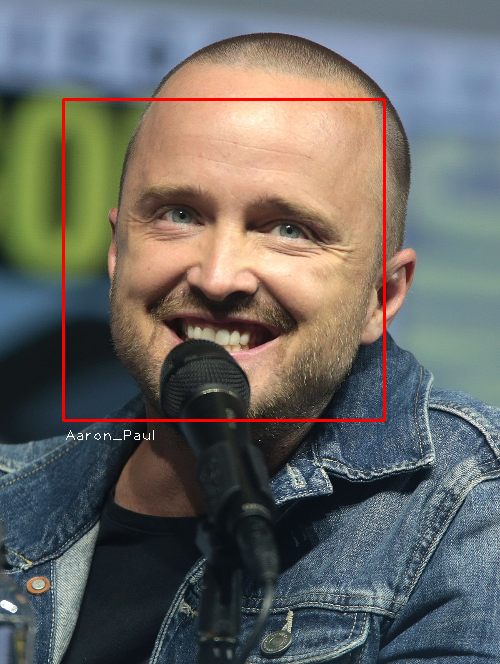

Processing 4.jpg


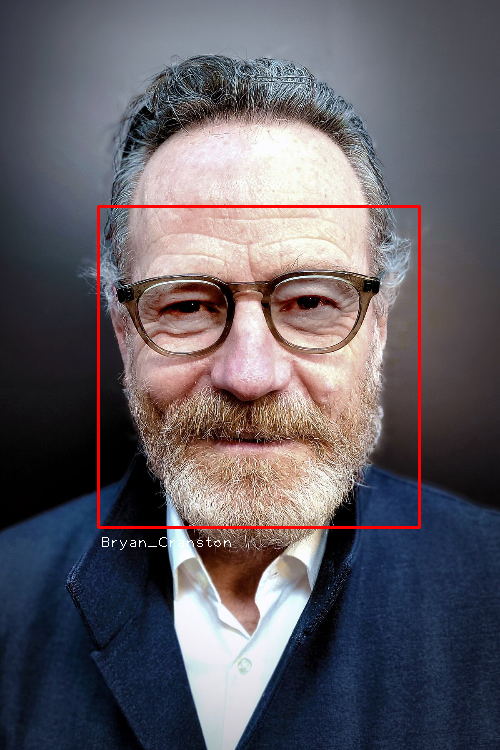

Processing 1.jpg
Processing 2.jpg


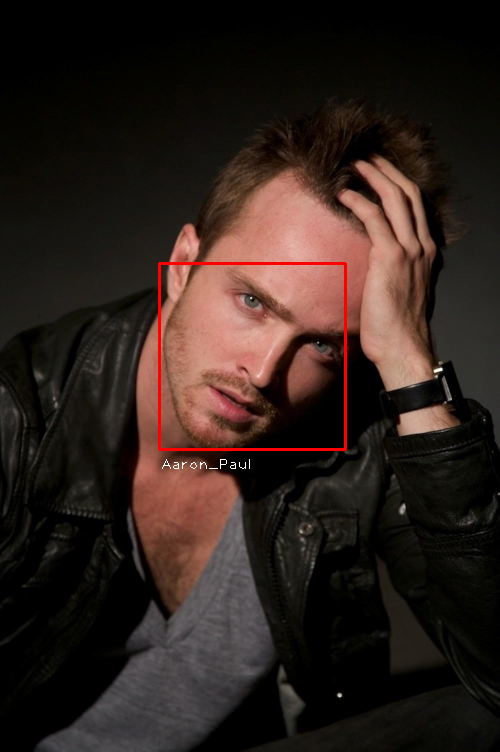

In [10]:
# Process test images
process_test_images('test', trained_encodings, trained_names)

In [11]:
# Process live video stream
process_video_stream(trained_encodings, trained_names)